In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

In [2]:
def calibrate_camera(nx, ny, image_name_mask):
    """
    Calibrate cameara and return camera matrix and istortion cooficients 
    """     
    
    #get all images from the calibration folder
    images = glob.glob(image_name_mask)
    
    #define object points and image points
    obj_points = []
    image_points = []
    
    #iterate through all images in the calibration folder
    for image_name in images:
        obj_p = np.zeros((nx * ny, 3), np.float32)
        obj_p[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
            
        image = cv2.imread(image_name)
        
        # Convert image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        #find inner conners of the chessboard
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
        #if conners are determined add this image for the camera calibration
        if ret == True:
            image_points.append(corners)
            obj_points.append(obj_p)

            # Draw and display the corners
            #cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
            #plt.imshow(image)
            #plt.show()
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, image_points, gray.shape[::-1], None, None)    
    
    return ret, mtx, dist, rvecs, tvecs
    

In [3]:
#define folder with name mask where chessboard images are stored for camera calibration
image_name_mask = 'camera_cal\calibration*.jpg'

#define number of corners to find - we have  
nx = 9
ny = 6

#calibrate camera to get camera matrix and distortion cooficients
ret, mtx, dist, rvecs, tvecs = calibrate_camera(nx, ny, image_name_mask)

In [4]:
def undistort(image, mtx, dist):
    """
    Undistort image using camera matrix and distortion cooficients 
    """     
    return cv2.undistort(image, mtx, dist, None, mtx)

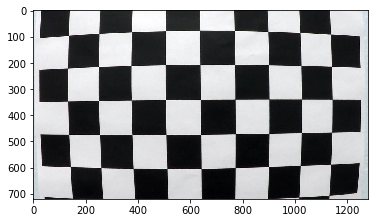

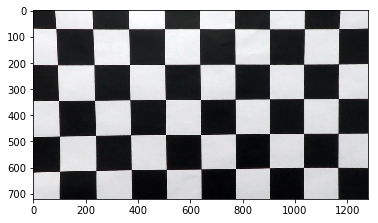

In [5]:
#test undistortion operation on the chessboard image
image_name = 'camera_cal\calibration1.jpg'
image = cv2.imread(image_name)
dst = undistort(image, mtx, dist)
plt.imshow(image)
plt.show()

plt.imshow(dst)
plt.show()

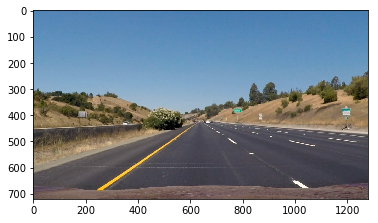

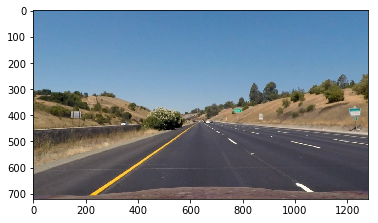

In [6]:
#test undistortion operation on the road image

image_name = 'test_images\straight_lines1.jpg'
image = mpimg.imread(image_name)

plt.imshow(image)
plt.show()

image = undistort(image, mtx, dist)
plt.imshow(image)
plt.show()
    

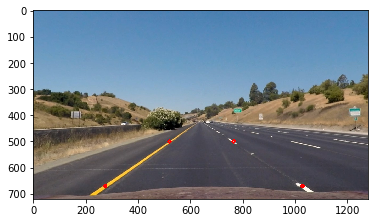

In [7]:
#define rectangular region on the flat stright road to determine perspective transform

image_points = np.copy(image)
cv2.circle(image_points, (275,670), 5, color=255, thickness=5)
cv2.circle(image_points, (1030,670), 5, color=255, thickness=5)
cv2.circle(image_points, (521,500), 5, color=255, thickness=5)
cv2.circle(image_points, (766,500), 5, color=255, thickness=5)


plt.imshow(image_points)
plt.show()

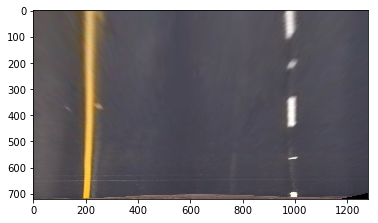

In [8]:
#use coordinatres above and open CV to calculate perspective transform matrix and inversed matrix
src = np.float32([(275,670), (1030,670), 
                   (766,500), (521,500)])
    
dst = np.float32([[200, 700], [1000, 700],
                    [1000, 400], [200, 400]])

#Find matrix
M = cv2.getPerspectiveTransform(src, dst)

#Find inversed matrix
Minv = cv2.getPerspectiveTransform(dst, src)

#Restore flat road from the image above 
warped = cv2.warpPerspective(image, M, dsize=(1280, 720))
plt.imshow(warped)
plt.show()

In [9]:
def warpPerspective(image):
    warped = cv2.warpPerspective(image, M, dsize=(1280, 720))
    return warped

In [10]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grad = cv2.Sobel(gray, cv2.CV_64F, 1 if orient == 'x' else 0, 1 if orient == 'y' else 0, ksize=sobel_kernel)
    grad = np.abs(grad)
    max_grad = np.max(grad)
    grad = np.uint8(grad * 255 / max_grad)
    mask = np.zeros_like(grad, np.float32)
    mask[(grad >= thresh[0]) & (grad <= thresh[1])] = 1
    
    return mask

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag = np.sqrt(grad_x * grad_x + grad_y * grad_y)
    max_mag = np.max(mag)
    mag = np.uint8(mag * 255 / max_mag)
    mask = np.zeros_like(mag, np.float32)
    mask[(mag >= mag_thresh[0]) & (mag <= mag_thresh[1])] = 1
    
    return mask

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    grad_x = np.abs(grad_x)
    grad_y = np.abs(grad_y)
        
    dir = np.arctan2(grad_y, grad_x)
    
    mask = np.zeros_like(dir)
    mask[(dir >= thresh[0]) & (dir <= thresh[1])] = 1
    
    return mask

def hls_select(image, thresh=(0, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    mask = np.zeros_like(s)
    mask[(s >= thresh[0]) & (s <= thresh[1])] = 1
    return mask

In [20]:
def find_lines(image, nwindows = 18, show_debug=False):
    # Set the width of the windows +/- margin
    margin = 125
    
    # Set minimum number of pixels found to recenter window
    minpix = 100
        
    #make a copy of input image
    img = np.copy(image)  
    
    #find historgram to determine starting points on thebottom on image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    
    if show_debug:
        plt.plot(histogram)
        plt.show()

    out_img = np.uint8(np.dstack((img, img, img)) * 255)

    midpoint = np.int(histogram.shape[0]/2)

    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(img.shape[0] / nwindows)

    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1) * window_height
        win_y_high = img.shape[0] - window * window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)    
    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if show_debug:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
    
    return ploty, left_fitx, right_fitx
    

In [26]:
def pipline(image, step_completed = None):
    
    #undistort initial image
    undist = undistort(image, mtx, dist)
    
    grad_dir = dir_threshold(undist, sobel_kernel=15, thresh=(0.7, 1.3))
    
    if (step_completed != None):
        step_completed(grad_dir, 'gray')
    
    grad_mag = mag_thresh(undist, sobel_kernel=31, mag_thresh=(50, 255))
    
    if (step_completed != None):
        step_completed(grad_mag, 'gray')
    
    combined = np.zeros_like(grad_dir)
    combined[((grad_mag == 1) & (grad_dir == 1))] = 1
    
    if (step_completed != None):
        step_completed(combined, 'gray')
    
    hls_s = hls_select(undist, thresh=(130, 255))
  
    if (step_completed != None):
        step_completed(hls_s, 'gray')
  
    out_img = np.dstack((hls_s, hls_s, hls_s)) * 255
    
    if (step_completed != None):
        step_completed(out_img, 'gray')
    
    hls_s = abs_sobel_thresh(out_img, orient='x', sobel_kernel=15, thresh=(100, 255))
        
    if (step_completed != None):
        step_completed(hls_s, 'gray')
  
    combined_res = np.zeros_like(hls_s)
    combined_res[((hls_s == 1) | (combined == 1))] = 1
    
    if (step_completed != None):
        step_completed(combined_res, 'gray')
    
    res = warpPerspective(combined_res)
    
    if (step_completed != None):
        step_completed(res, 'gray')
    
    return res

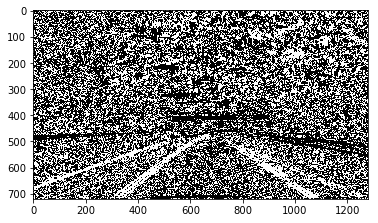

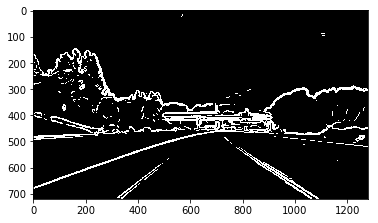

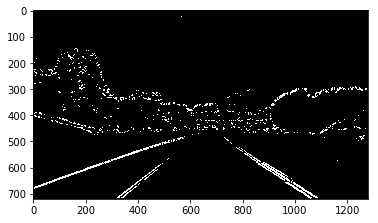

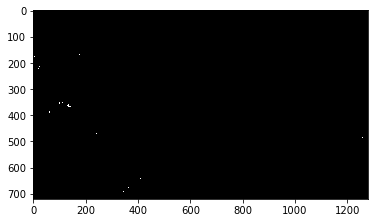

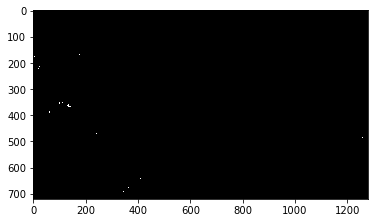

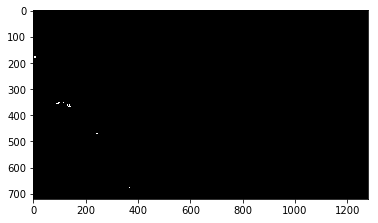

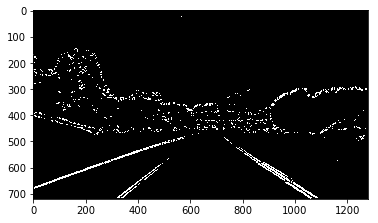

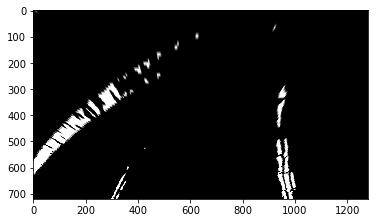

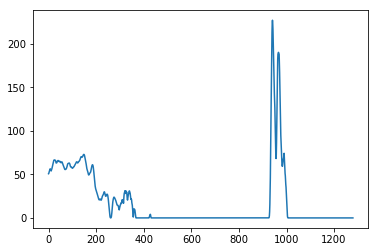

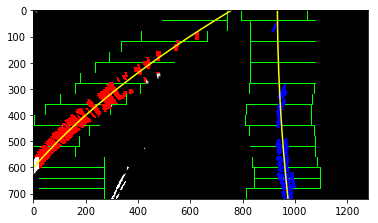

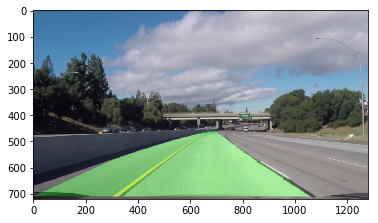

In [34]:
def draw(image, cmap):
    plt.imshow(image, cmap=cmap)
    plt.show()

image_name = 'test_images/test0.jpg'
image = mpimg.imread(image_name)

res_image = pipline(image, step_completed = draw)

ploty, left_fitx, right_fitx = find_lines(res_image, show_debug=True)

warped = res_image

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.show()


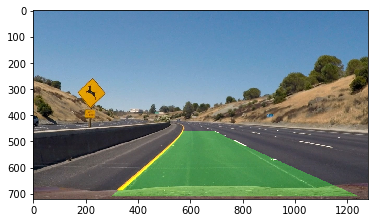

In [33]:
image_name = 'test_images/test2.jpg'
image = mpimg.imread(image_name)

res_image = pipline(image)

ploty, left_fitx, right_fitx = find_lines(res_image, show_debug=False)

warped = res_image

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.show()

In [29]:
def process_image(image):
    res_image = pipline(image)

    ploty, left_fitx, right_fitx = find_lines(res_image, show_debug=False)

    warped = res_image

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result

In [30]:
#prepare environment to work with video

import imageio
imageio.plugins.ffmpeg.download()

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [18]:
clip1_name = "challenge_video.mp4"
#clip1 = VideoFileClip("challenge_video.mp4")

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(clip1_name))

In [35]:
clip1_name = "project_video.mp4"
white_output = 'project_video_updated.mp4'
clip1 = VideoFileClip(clip1_name)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_updated.mp4
[MoviePy] Writing video project_video_updated.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:31<00:00,  1.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_updated.mp4 

Wall time: 5min 31s


In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((img, img, img))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

In [ ]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images
plt.show()

In [ ]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

In [ ]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

In [ ]:
warped = img

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.show()